In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
#preprocessing for efficient net

IMG_SIZE = 224
BATCH_SIZE = 32

# Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

# No augmentation for validation and test sets
val_test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Paths to train, val, and test directories
train_dir = "chest_xray/train"
val_dir = "chest_xray/validation"
test_dir = "chest_xray/test"

# Load each set
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 4694 images belonging to 2 classes.
Found 585 images belonging to 2 classes.
Found 586 images belonging to 2 classes.


In [13]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Get a batch of images and labels
# image_batch, label_batch = next(train_generator)

# # Number of images to display
# num_images = 10

# # Iterate over the batch and plot each image

# fig, axes = plt.subplots(2, 5, figsize=(15, 6))
# for i in range(num_images):
#     row = i // 5
#     col = i % 5
#     axes[row, col].imshow(image_batch[i])
#     axes[row, col].axis('off')
    
#     # Display label (0 or 1), where 0 might indicate 'Normal' and 1 'Pneumonia'
#     label = label_batch[i]
#     class_name = 'Normal' if label == 0 else 'Pneumonia'
#     axes[row, col].set_title(class_name, color='red')

# plt.tight_layout()
# plt.show()

# Addressing issue 2

In [14]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the pre-trained EfficientNet-B0 model without the top layer
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze the base model layers to retain pre-trained weights initially
base_model.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)  
x = Dense(128, activation='relu')(x) 
x= Dropout(0.4)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=x)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# model.summary()

# adding normalization and dropuout layers

In [17]:
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import AdamW
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(128, activation='relu')(x)
#conv1d
x = BatchNormalization()(x)
x = Dropout(0.3)(x) 

x = Dense(1, activation='sigmoid')(x)

# final model
model = Model(inputs=base_model.input, outputs=x)

lr_schedule = ExponentialDecay(initial_learning_rate=1e-3, decay_steps=10000, decay_rate=0.9)

# Use AdamW with the schedule
optimizer = AdamW(learning_rate=lr_schedule)

# Compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
# model.summary()

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

#early stopping(patience)
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=146,
    validation_data=val_generator,
    validation_steps=18,
    epochs=50,
    verbose=2,
    callbacks=[early_stopping]
)

Epoch 1/50
146/146 - 369s - 3s/step - accuracy: 0.9339 - loss: 0.2105 - val_accuracy: 0.7292 - val_loss: 2.8383
Epoch 2/50
146/146 - 3s - 19ms/step - accuracy: 0.9375 - loss: 0.0569 - val_accuracy: 0.7778 - val_loss: 0.9620
Epoch 3/50
146/146 - 377s - 3s/step - accuracy: 0.9337 - loss: 0.2051 - val_accuracy: 0.8819 - val_loss: 0.3331
Epoch 4/50
146/146 - 3s - 18ms/step - accuracy: 1.0000 - loss: 0.0279 - val_accuracy: 0.8889 - val_loss: 0.1925
Epoch 5/50
146/146 - 350s - 2s/step - accuracy: 0.9462 - loss: 0.1651 - val_accuracy: 0.7326 - val_loss: 0.4857
Epoch 6/50
146/146 - 3s - 19ms/step - accuracy: 0.8750 - loss: 0.1254 - val_accuracy: 0.4444 - val_loss: 0.4755
Epoch 7/50
146/146 - 523s - 4s/step - accuracy: 0.9455 - loss: 0.1475 - val_accuracy: 0.9219 - val_loss: 0.7691
Epoch 8/50
146/146 - 3s - 19ms/step - accuracy: 0.9062 - loss: 0.0737 - val_accuracy: 1.0000 - val_loss: 0.0293
Epoch 9/50
146/146 - 410s - 3s/step - accuracy: 0.9550 - loss: 0.1241 - val_accuracy: 0.6007 - val_loss:

In [20]:
test_loss, test_accuracy = model.evaluate(
    test_generator,
    steps=586 // BATCH_SIZE,  # Total steps for test set
    verbose=1
)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 579ms/step - accuracy: 0.9558 - loss: 0.0910
Test Loss: 0.1271
Test Accuracy: 0.9427


19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 591ms/step


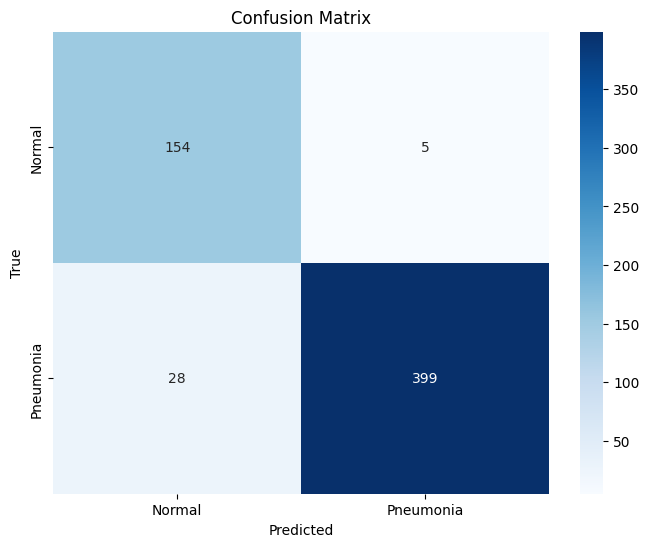

Classification Report:
               precision    recall  f1-score   support

      Normal       0.85      0.97      0.90       159
   Pneumonia       0.99      0.93      0.96       427

    accuracy                           0.94       586
   macro avg       0.92      0.95      0.93       586
weighted avg       0.95      0.94      0.94       586



In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict classes on the test set
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()

# True labels
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot 
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=['Normal', 'Pneumonia']))


#curves

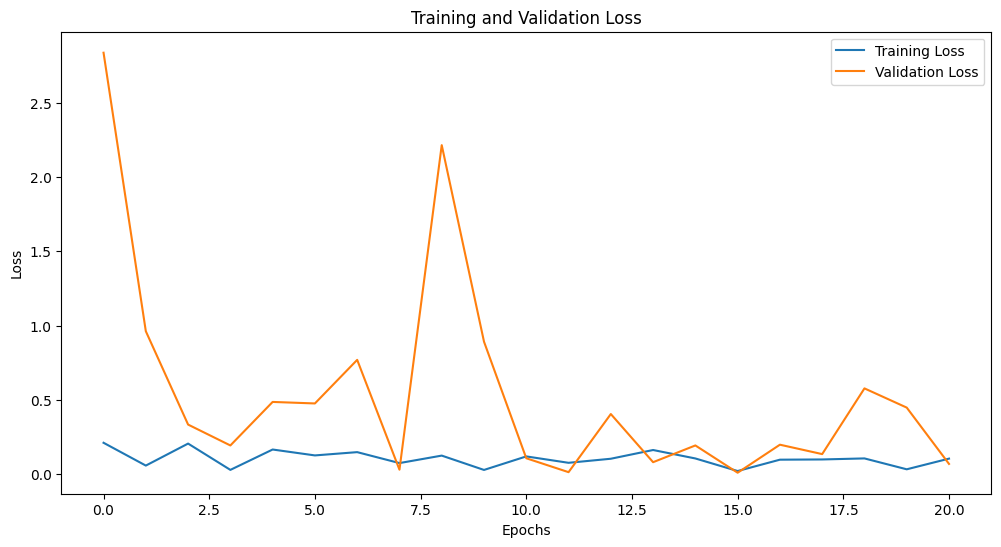

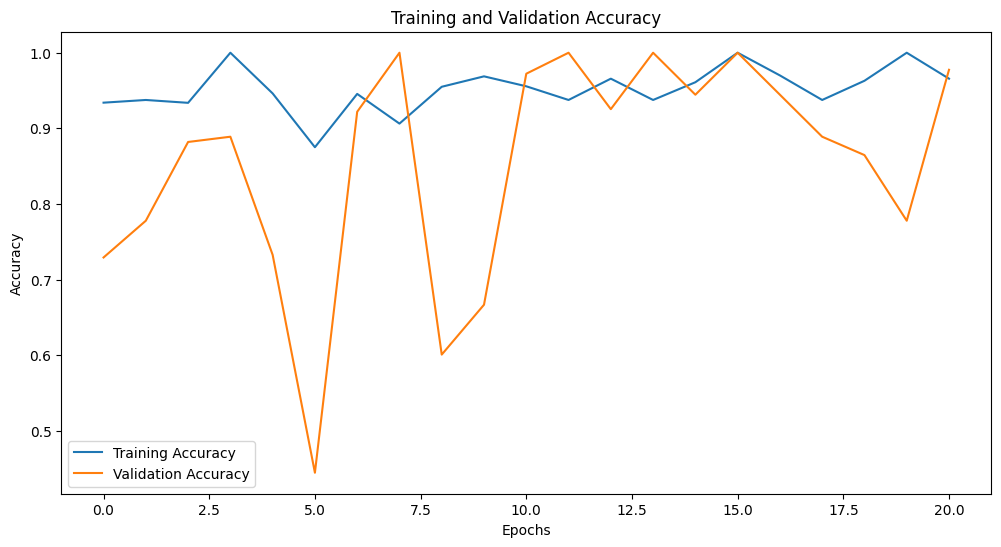

In [28]:
import matplotlib.pyplot as plt

# training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


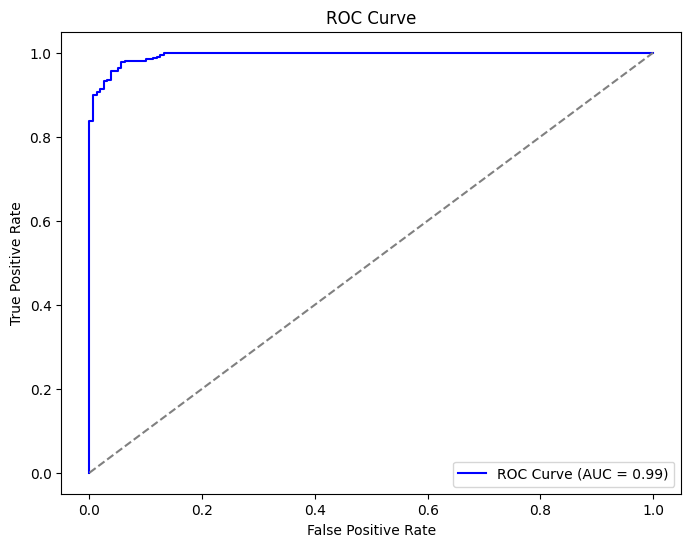

In [27]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()
